In [18]:
"""
Project for Olin College, Data Science, Spring 2017.

Data from:
https://www.nass.usda.gov/Surveys/Guide_to_NASS_Surveys/Bee_and_Honey/
http://usda.mannlib.cornell.edu/MannUsda/viewDocumentInfo.do?documentID=1191


unzip the csv zip files with

$  for VARIABLE in 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016; 
$  do   unzip *$VARIABLE.zip -d $VARIABLE; 
$  done

or pull them from my git.
"""

import numpy as np
import pandas
import os
import string
import itertools
import matplotlib.pyplot as plt
import thinkstats2

In [2]:
def get_all_csvs(csv_years=[2002+i for i in range(15)], csv_path="data/csvs/"):
    '''
    Returns a list of all csv files in the (hard-coded) year-directory combinations.
    '''
    all_csvs = []
    for i in csv_years:
        this_path = csv_path + str(i) + "/"
        these_files = os.listdir(this_path)
        these_csvs = [(this_path + i) for i in these_files if i[-4:] == ".csv"]
        all_csvs.extend(these_csvs)
    return all_csvs

In [3]:
class Csv_obj(object):
    def __init__(self, filename):
        self.name = filename
        year_start = filename.find("20")
        self.year = int(filename[year_start:year_start+4])
        self.data_type = filename[(filename.find("_") + 1) : (filename.find(".csv"))]
        # 001: honey type/color/grade to quantity, price for that year
        #   color class : price (cents per pound), 
        #   Co-op/private : Retail : All
        # 002: State, number of colonies (1000s), 
        #   Yield (per colony), Yield (total, 1000 lbs), stocks (1klbs),
        #   Average price per pound (cents),
        #   total value of production.
        # 003: 
        temp_df = sanitize_then_load_csv(filename)
        self.df = self.clean_df(temp_df)

    
    def __str__(self):
        return str(self.year) + ":" + self.data_type
    
    def clean_df(self, target):
        if self.data_type[-3:] == "002":
            col_names = ["state","colonies","yld","production","stocks","prices","totalval"]
                        # abbr,   1000s      lbs/col  1000 lbs    1000 lbs  cents    $1000s   
            final = target.drop(target.columns[0],1).drop(target.columns[1],1).dropna()
            final.columns = col_names
            final = final[final.state != "State"]
            return final
        else:
            return target # todo: clean; right now 002 is all we care about though.
    
    def isnull(self):
        if self.df is None:
            return True
        else:
            return False

In [4]:
def sanitize_then_load_csv(filename, min_col_length=9, max_col_length = None):
    """
    Gets around the metadata-y columns by scanning for the length of .split(',').
    TODO: make it ignore the "format"/grammatical commas which occur within a single entry in the csv.
    """
    f = open(filename)
    lines_to_skip = []
    for i, line in enumerate(f.readlines()):
        l_split = line.split(',') # will also split internal commas in strings. todo: fix. low priority.
        if len(l_split) < min_col_length:
            lines_to_skip.append(i)
        elif max_col_length != None:
            if len(l_split) > max_col_length:
                lines_to_skip.append(i)
    try:
        df = pandas.read_csv(filename, skiprows = lines_to_skip)
    except Exception as err:
        print "Cannot read: ", filename, "\t ", str(err)[str(err).find("Expected"):]
        df = None
    return df

In [5]:
all_csvs = get_all_csvs()

In [6]:
csv_objs = [Csv_obj(i) for i in all_csvs]

Cannot read:  data/csvs/2008/hony_all.csv 	  Expected 9 fields in line 155, saw 11

Cannot read:  data/csvs/2009/hony_all.csv 	  Expected 9 fields in line 155, saw 11

Cannot read:  data/csvs/2010/hony_all.csv 	  Expected 9 fields in line 155, saw 11

Cannot read:  data/csvs/2011/hony_all_tables.csv 	  Expected 9 fields in line 153, saw 11

Cannot read:  data/csvs/2012/hony_all_tables.csv 	  Expected 9 fields in line 152, saw 10

Cannot read:  data/csvs/2013/hony_all_tables.csv 	  Expected 9 fields in line 152, saw 10

Cannot read:  data/csvs/2014/hony_all_tables.csv 	  Expected 9 fields in line 151, saw 10

Cannot read:  data/csvs/2015/hony_all_tables.csv 	  Expected 9 fields in line 151, saw 10

Cannot read:  data/csvs/2016/hony_all_tables.csv 	  Expected 9 fields in line 166, saw 10

Cannot read:  data/csvs/2016/hony_p00a_t005.csv 	  e


In [7]:
relevants[0].df

NameError: name 'relevants' is not defined

In [9]:
abbrev_dict = { # USDA format changed around 2010.
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Other States 5/ 6/': 'Sts',
    'United States 6/ 7/': 'US'
}

index_to_name = { # for pyplot labeling purposes
    0: "Year",
    1: "Colony count (1000s)",
    2: "Yield (lbs per colony)",
    3: "Production (1000 lbs)",
    4: "Stocks (1000 lbs)",
    5: "Price (cents/lb)",
    6: "Total value ($1000s)",
    -1: "Colony count (% 2002)",
    -2: "Yield (% 2002)",
    -3: "Production (% 2002)",
    -4: "Stocks (% 2002)",
    -5: "Price (% 2002)",
    -6: "Total value (% 2002)"
}


In [10]:
relevants = [i for i in csv_objs if i.data_type[-3:] == "002"]

In [11]:
state_to_vals_dict = {}
for i in relevants:
    yr = i.year
    df = i.df
    for index, row in df.iterrows():
        if row.state in abbrev_dict:
            this_state = abbrev_dict[row.state]
        else:
            if row.state[:3] in ["Sts"," St"]:
                this_state = "Sts"
            elif row.state[:2] == "US":
                this_state = "US"
            else:
                this_state = row.state
        this_tup = (yr, row.colonies, row.yld, row.production, row.stocks, row.prices, row.totalval)
        if this_state in state_to_vals_dict:
            state_to_vals_dict[this_state].append(this_tup)
        else:
            state_to_vals_dict[this_state] = [this_tup]

In [12]:
for i in state_to_vals_dict.keys():
    state_to_vals_dict[i] = sorted(state_to_vals_dict[i])

In [13]:
def plot_vals(states=["US","CA","AZ","Sts","ND"],target_x = 0, target_y=1, as_pct=True):
    '''
    plots the target_x against target_y for [states]
    as_pct = plots yvalues as percent of first value, in 2002.
    Default: colony count vs year, as percent of 2002.
    
    [year, colonies (1k), yield (lbs/col),
    production (1k lbs), stocks (1k lbs), 
    price (cents), totalval ($1k)]
    '''
    for state in states:
        data = state_to_vals_dict[state]
        xs = [i[target_x] for i in data]
        ys = [i[target_y] for i in data]
        if as_pct:
            ys = [float(i)/float(ys[0]) for i in ys]
        plt.plot(xs, ys, label=state)
    if as_pct:
        xname = index_to_name[target_x * -1]
        yname = index_to_name[target_y * -1]
    else:
        xname = index_to_name[target_x]
        yname = index_to_name[target_y]
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend(loc=0)
    plt.show()

def scatter_all(target_x=2, target_y=5, as_pct_x=False, as_pct_y=False):
    '''
    scatters the x vs the y for all states, years.
    Default: honey price vs. honey production per colony.
    '''
    tups = []
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
#         print(data)
        xs = [i[target_x] for i in data]
        ys = [i[target_y] for i in data]
        if as_pct_x:
            xs = [float(i)/float(xs[0]) for i in xs]
        if as_pct_y:
            ys = [float(i)/float(ys[0]) for i in ys]
        tups.extend(zip(xs, ys))            
    if as_pct_x:
        xname = index_to_name[target_x * -1]
    else:
        xname = index_to_name[target_x]
    if as_pct_y:
        yname = index_to_name[target_y * -1]
    else:
        yname = index_to_name[target_y]
    
    xvals, yvals = zip(*tups) 
    plt.scatter(xvals, yvals)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.show()
        
def scatter_hilo(target_x=2, target_y=5, as_pct_x=False, as_pct_y=False):
    '''
    scatters the x vs the y for all states, years.
    colors high and low-producing states differently.
    Default: honey price vs. honey production per colony.
    '''
    tups_high = []
    tups_low = []
    prod_means = []
    
    for state in state_to_vals_dict.keys():
        prods = [i[3] for i in state_to_vals_dict[state]]
        prods_np = np.array(prods).astype(np.float)
        mean = np.mean(prods_np)
        prod_means.append(mean)
        
    m = np.mean(prod_means)
    
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
        mean_prod = np.mean([int(i[3]) for i in data])
        
        xs = [float(i[target_x]) for i in data]
        ys = [float(i[target_y]) for i in data]
        if as_pct_x:
            xs = [float(i)/float(xs[0]) for i in xs]
        if as_pct_y:
            ys = [float(i)/float(ys[0]) for i in ys]
        
        if mean_prod > m:
            tups_high.extend(zip(xs, ys))
        else:
            tups_low.extend(zip(xs, ys))
            
    if as_pct_x:
        xname = index_to_name[target_x * -1]
    else:
        xname = index_to_name[target_x]
    if as_pct_y:
        yname = index_to_name[target_y * -1]
    else:
        yname = index_to_name[target_y]
    
    xvals_high, yvals_high = zip(*tups_high) 
    xvals_low, yvals_low = zip(*tups_low)
#     print "high:\t", thinkstats2.Corr(xvals_high, yvals_high)
#     print "low:\t", thinkstats2.Corr(xvals_low, yvals_low)
    plt.scatter(xvals_low, yvals_low, c='r', s=14, linewidths=0)
    plt.scatter(xvals_high, yvals_high, c='b', s=20, linewidths=0)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.show()

    
def corr_one(target_x=2, target_y=5):
    '''
    Gets the correlation between target_x and target_y.
    Default: honey price vs. honey production per colony.
    '''
    tups = []
    for state in state_to_vals_dict.keys():
        data = state_to_vals_dict[state]
        xs = [float(i[target_x]) for i in data]
        ys = [float(i[target_y]) for i in data]
        tups.extend(zip(xs, ys))  
    xvals, yvals = zip(*tups) 
    return thinkstats2.Corr(xvals, yvals)

def corr_all():
    '''
    Checks all combinations of x and y for correlation.
    '''
    all_corrs = []
    for x in range(7):
        for y in range(x+1,7):
            this_corr = corr_one(target_x=x, target_y=y)
            all_corrs.append((this_corr,index_to_name[x],index_to_name[y]))
    return sorted(all_corrs,reverse=True)

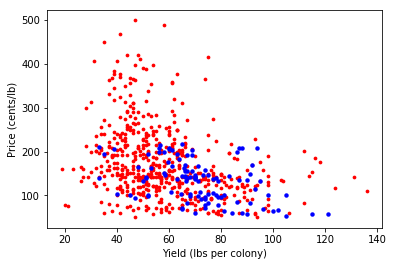

In [14]:
# plot_vals()
# scatter_all()
scatter_hilo()

In [15]:
corr_all()

[(0.99076004812331875, 'Colony count (1000s)', 'Production (1000 lbs)'),
 (0.97057792691681499, 'Production (1000 lbs)', 'Stocks (1000 lbs)'),
 (0.95567981257964019, 'Colony count (1000s)', 'Total value ($1000s)'),
 (0.94799959652632859, 'Colony count (1000s)', 'Stocks (1000 lbs)'),
 (0.93177815055657132, 'Production (1000 lbs)', 'Total value ($1000s)'),
 (0.84145313764376728, 'Stocks (1000 lbs)', 'Total value ($1000s)'),
 (0.692100969187879, 'Year', 'Price (cents/lb)'),
 (0.14995041663077072, 'Yield (lbs per colony)', 'Production (1000 lbs)'),
 (0.14819878941664169, 'Yield (lbs per colony)', 'Stocks (1000 lbs)'),
 (0.10560255418998386, 'Yield (lbs per colony)', 'Total value ($1000s)'),
 (0.10153966975193587, 'Colony count (1000s)', 'Yield (lbs per colony)'),
 (0.081694920900981724, 'Year', 'Total value ($1000s)'),
 (0.012909067882169367, 'Year', 'Colony count (1000s)'),
 (-0.013858931107513345, 'Year', 'Production (1000 lbs)'),
 (-0.047063856821921261, 'Year', 'Stocks (1000 lbs)'),
 (

In [19]:
def compare_states(state1, state2):
    data1 = state_to_vals_dict[state1]
    data2 = state_to_vals_dict[state2]
    state1 = [float(i[2]) for i in data1]
    state2 = [float(i[2]) for i in data2]
    if len(state1) == len(state2):
        return thinkstats2.Corr(state1, state2)
    else:
        return -1

In [20]:
correlations = []
i = 1
for pair in itertools.combinations(state_to_vals_dict.keys(),2):
    i += 1
    correlations.append((pair[0], pair[1], compare_states(pair[0],pair[1])))

In [22]:
correlations.sort(reverse=True, key = lambda item: item[2])
for i in correlations:
    print (i)

('AL', 'OR', 0.92444604969462518)
('ND', 'US', 0.88772767273481834)
('WA', 'AL', 0.87588413100069329)
('WA', 'OR', 0.85292707841749649)
('ID', 'UT', 0.83838207361217698)
('FL', 'US', 0.83002354230335917)
('ND', 'MO', 0.82811846455419347)
('AL', 'UT', 0.82724472737566823)
('AL', 'ID', 0.8135811878267678)
('HI', 'NY', 0.80779349744862339)
('MN', 'US', 0.80721876737274412)
('FL', 'AL', 0.80695899654219716)
('WI', 'AL', 0.80640036979899077)
('WI', 'FL', 0.80032870936843714)
('WA', 'ID', 0.79433260746673051)
('FL', 'MN', 0.78692412990618177)
('AL', 'MN', 0.78199010266682489)
('WI', 'OR', 0.77753287046756103)
('MN', 'OR', 0.77686711605189285)
('CA', 'US', 0.77451560590177571)
('WA', 'UT', 0.7681144220059869)
('WI', 'IA', 0.76785992100233469)
('WA', 'CO', 0.76688559722463856)
('WI', 'MN', 0.7661231681253855)
('VT', 'IL', 0.76531753110821843)
('WA', 'FL', 0.76487059017290771)
('NY', 'MI', 0.76362146831558653)
('NY', 'AL', 0.75796177376903417)
('CO', 'UT', 0.74959972639133676)
('ND', 'CA', 0.74

# Production and Supply

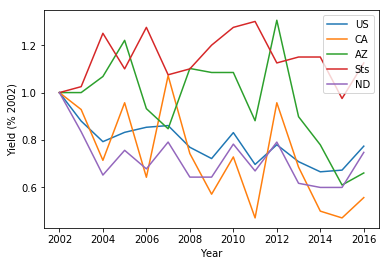

In [26]:
plot_vals(states=["US","CA","AZ","Sts","ND"],target_y=2)
#Plotting production for interesting states

In [42]:
stock_production_correlation = []
for state in state_to_vals_dict.keys():
    data = state_to_vals_dict[state]
    #Checking correlation between production one year and stocks next year
    production = [int(i[3]) for i in data]
    stocks = [float(i[2]) for i in data]
    production = production[:-1]
    stocks = stocks[1:]
    corr = thinkstats2.Corr(stocks, production)
    stock_production_correlation.append((state, corr))

stock_production_correlation.sort(reverse = True, key = lambda item: item[1])
for state, correlation in stock_production_correlation:
    print(state + ': ' + str(correlation))

AL: 0.831100216291
AR: 0.787202276174
MD: 0.755928946018
MS: 0.71025891778
FL: 0.669995593959
WI: 0.669742364832
US: 0.617915121465
VT: 0.570102953158
IA: 0.492600996383
WY: 0.480752645172
WA: 0.469726895537
MN: 0.466728167317
NY: 0.457766000839
MO: 0.44815645544
AZ: 0.443562376929
LA: 0.427669131109
UT: 0.395993416297
TX: 0.366505771207
NM: 0.354662519265
WV: 0.328463546573
NV: 0.317766602314
ID: 0.317569298177
CO: 0.28759458476
IL: 0.260612654397
MI: 0.24824398889
OH: 0.202784407413
CA: 0.193194057599
VA: 0.184074151373
PA: 0.144036581522
ME: 0.134726674535
IN: 0.116988157426
NJ: 0.0613815535038
KS: -0.0520931992307
SD: -0.0737146500659
GA: -0.0762246963356
HI: -0.107266187036
SC: -0.114707866935
OR: -0.124155182858
MT: -0.143340431923
NE: -0.147733911112
ND: -0.174675731755
NC: -0.176169103589
OK: -0.184739016632
TN: -0.269238209952
KY: -0.283368335128
Sts: -0.490079066799


They aren't especially well correlated.